In [1]:
# Import the things needed
import os

import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.utils import make_grid

%matplotlib inline

In [2]:
# Define the constants needed
latent_size = 128
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [3]:
# Define the utility methods we need
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [8]:
# Define the models and load the exported models
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

# Load the Saved models
## MAP Them to use CPU, so It would work for any machine
generator.load_state_dict(torch.load("generator_model.bin", map_location=torch.device('cpu')))
discriminator.load_state_dict(torch.load("discriminator_model.bin", map_location=torch.device('cpu')))

# Finally, Evaluate them
generator.eval()
discriminator.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

In [14]:
# Define the method we need for generating, and saving images
from torchvision.utils import save_image

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, show=True):
    latent_tensors = torch.randn(64, latent_size, 1, 1, device=torch.device('cpu'))

    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)

    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)

    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [10]:
# Demo generating a random image, before starting the epoch loop
def generate_and_show_random_image():
    xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
    fake_images = generator(xb)

    show_images(fake_images)

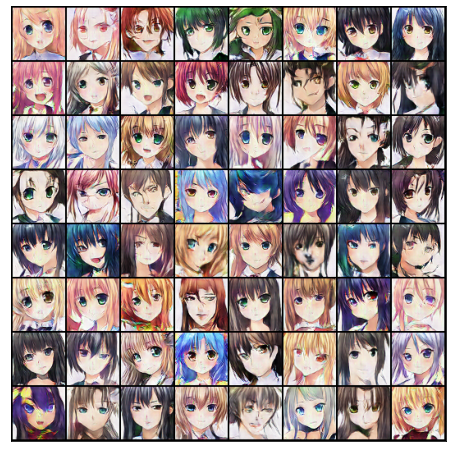

In [11]:
# Test generation
generate_and_show_random_image()

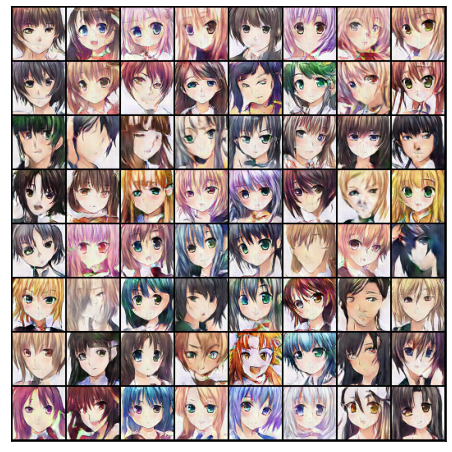

In [12]:
generate_and_show_random_image()

In [15]:
# Since it works pretty well, We can now generate images
## Using 20 epoch for Demo purposes
for epoch in range(20):
  save_samples(epoch + 1, show=False)

Saving generated-images-0001.png
Saving generated-images-0002.png
Saving generated-images-0003.png
Saving generated-images-0004.png
Saving generated-images-0005.png
Saving generated-images-0006.png
Saving generated-images-0007.png
Saving generated-images-0008.png
Saving generated-images-0009.png
Saving generated-images-0010.png
Saving generated-images-0011.png
Saving generated-images-0012.png
Saving generated-images-0013.png
Saving generated-images-0014.png
Saving generated-images-0015.png
Saving generated-images-0016.png
Saving generated-images-0017.png
Saving generated-images-0018.png
Saving generated-images-0019.png
Saving generated-images-0020.png


In [16]:
# That worked great! Time to export into a video!
def generate_video(generated_location, save_filename):
    files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if generated_location in f]
    files.sort()

    out = cv2.VideoWriter(save_filename, cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
    [out.write(cv2.imread(fname)) for fname in files]
    out.release()

    print("Done, Exported as {}".format(save_filename))

In [17]:
generate_video("generated", "exported_model_generation.avi")

Done, Exported as exported_model_generation.avi
